In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import json
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision import transforms as T
from PIL import Image
from timm import create_model
import torchvision
import torch.nn as nn
from torchvision.ops import generalized_box_iou_loss
import torch.nn.functional as F


class COCODataset(Dataset):
    def __init__(self, root, annotation_file, transforms=None):
        self.root = root
        self.transforms = transforms
        with open(annotation_file, 'r') as f:
            self.coco_data = json.load(f)
        self.images = {image['id']: image for image in self.coco_data['images']}
        self.annotations = self.coco_data['annotations']
        self.annotation_map = {}
        for ann in self.annotations:
            if ann['image_id'] not in self.annotation_map:
                self.annotation_map[ann['image_id']] = []
            self.annotation_map[ann['image_id']].append(ann)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image_info = list(self.images.values())[idx]
        img_path = os.path.join(self.root, image_info['file_name'])
        image = Image.open(img_path).convert("RGB")
        image = image.resize((224, 224))

        boxes, labels = [], []
        for ann in self.annotation_map[image_info['id']]:
            x, y, width, height = ann['bbox']
            x_scale = 224 / image_info['width']
            y_scale = 224 / image_info['height']
            boxes.append([x * x_scale, y * y_scale, (x + width) * x_scale, (y + height) * y_scale])
            labels.append(ann['category_id'])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        target = {"boxes": boxes, "labels": labels}

        if self.transforms:
            image = self.transforms(image)

        return image, target


data_transforms = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor()
])


class SwinBackboneWrapper(nn.Module):
    def __init__(self, model, out_channels=256):
        super(SwinBackboneWrapper, self).__init__()
        self.model = model
        self.out_channels = out_channels

        in_channels = model.feature_info.channels()[-1]

        self.adjust_conv = nn.Conv2d(in_channels, self.out_channels, kernel_size=1)


    def forward(self, x):
        features = self.model(x)

        adjusted_features = [self.adjust_conv(features[-1].permute(0, 3, 1, 2))]

        return {f"layer{i}": feat for i, feat in enumerate(adjusted_features)}

swin_model = create_model('swin_base_patch4_window7_224', pretrained=True, features_only=True)
swin_backbone = SwinBackboneWrapper(swin_model, out_channels=256)


anchor_generator = AnchorGenerator(
    sizes=((32, 64, 128, 256, 512),),
    aspect_ratios=((0.5, 1.0, 2.0),) * len(swin_model.feature_info.channels())
)


roi_pooler = torchvision.ops.MultiScaleRoIAlign(
    featmap_names=[f"layer{i}" for i in range(len(swin_model.feature_info.channels()))],
    output_size=7,
    sampling_ratio=2
)


model = FasterRCNN(swin_backbone, num_classes=4, rpn_anchor_generator=anchor_generator, box_roi_pool=roi_pooler)

model.transform.image_mean = [0.485, 0.456, 0.406]
model.transform.image_std = [0.229, 0.224, 0.225]
model.transform.min_size = (224,)
model.transform.max_size = 224

dataset = COCODataset(root='/content/drive/MyDrive/CSE 507/newtbx/images', annotation_file='/content/drive/MyDrive/CSE 507/newtbx/maxnewtraindatajson', transforms=data_transforms)
dataloader = DataLoader(dataset, batch_size=2, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))


optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=0.01)



num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for images, targets in dataloader:
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        epoch_loss += losses.item()

    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}")









/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public m

model.safetensors:   0%|          | 0.00/353M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/353M [00:00<?, ?B/s]

Epoch [1/10], Loss: 31.0232
Epoch [1/10], Loss: 31.0232
Epoch [2/10], Loss: 24.3948
Epoch [2/10], Loss: 24.3948
Epoch [3/10], Loss: 24.1010
Epoch [3/10], Loss: 24.1010
Epoch [4/10], Loss: 21.7416
Epoch [4/10], Loss: 21.7416
Epoch [5/10], Loss: 21.3266
Epoch [5/10], Loss: 21.3266
Epoch [6/10], Loss: 21.3378
Epoch [6/10], Loss: 21.3378
Epoch [7/10], Loss: 19.1730
Epoch [7/10], Loss: 19.1730
Epoch [8/10], Loss: 17.6307
Epoch [8/10], Loss: 17.6307
Epoch [9/10], Loss: 17.1288
Epoch [9/10], Loss: 17.1288
Epoch [10/10], Loss: 16.9048
Epoch [10/10], Loss: 16.9048


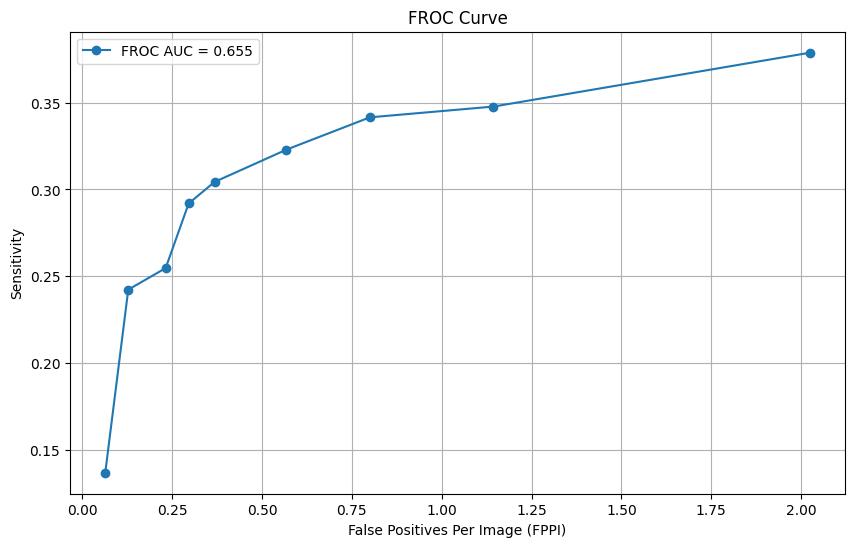

FROC AUC: 0.6551


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import auc

def calculate_froc_auc(model, dataloader, iou_threshold=0.5, confidence_thresholds=np.arange(0.1, 1.0, 0.1)):

    model.eval()
    all_ground_truths = []
    all_predictions = []

    with torch.no_grad():
        for images, targets in dataloader:
            outputs = model(images)

            for target, output in zip(targets, outputs):
                gt_boxes = target['boxes'].numpy()
                pred_boxes = output['boxes'].numpy()
                scores = output['scores'].numpy()

                all_ground_truths.append(gt_boxes)
                all_predictions.append((pred_boxes, scores))

    sensitivities = []
    fppi_values = []
    num_images = len(all_ground_truths)

    for conf_thresh in confidence_thresholds:
        tp = 0
        fp = 0
        fn = 0

        for gt_boxes, (pred_boxes, scores) in zip(all_ground_truths, all_predictions):

            filtered_preds = pred_boxes[scores >= conf_thresh]

            matched_gt = np.zeros(len(gt_boxes), dtype=bool)
            for pred_box in filtered_preds:
                ious = calculate_iou(pred_box, gt_boxes)
                max_iou_idx = np.argmax(ious)
                if ious[max_iou_idx] >= iou_threshold and not matched_gt[max_iou_idx]:
                    matched_gt[max_iou_idx] = True
                    tp += 1
                else:
                    fp += 1

            fn += np.sum(~matched_gt)

        sensitivity = tp / (tp + fn + 1e-6)
        fppi = fp / num_images

        sensitivities.append(sensitivity)
        fppi_values.append(fppi)


    froc_auc = auc(fppi_values, sensitivities)


    plt.figure(figsize=(10, 6))
    plt.plot(fppi_values, sensitivities, marker='o', label=f"FROC AUC = {froc_auc:.3f}")
    plt.xlabel("False Positives Per Image (FPPI)")
    plt.ylabel("Sensitivity")
    plt.title("FROC Curve")
    plt.legend()
    plt.grid()
    plt.show()

    return froc_auc, sensitivities, fppi_values

def calculate_iou(box1, boxes2):

    x1 = np.maximum(box1[0], boxes2[:, 0])
    y1 = np.maximum(box1[1], boxes2[:, 1])
    x2 = np.minimum(box1[2], boxes2[:, 2])
    y2 = np.minimum(box1[3], boxes2[:, 3])

    inter_area = np.maximum(0, x2 - x1) * np.maximum(0, y2 - y1)
    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    boxes2_area = (boxes2[:, 2] - boxes2[:, 0]) * (boxes2[:, 3] - boxes2[:, 1])

    union_area = box1_area + boxes2_area - inter_area
    ious = inter_area / (union_area + 1e-6)
    return ious


test_dataset = COCODataset(
    root='/content/drive/MyDrive/CSE 507/newtbx/test',
    annotation_file='/content/drive/MyDrive/CSE 507/newtbx/maxnewtestdatajson',
    transforms=data_transforms
)
test_dataloader = DataLoader(test_dataset, batch_size=2, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))

froc_auc, sensitivity, fppi = calculate_froc_auc(model, test_dataloader)
print(f"FROC AUC: {froc_auc:.4f}")


In [ ]:
torch.save(model, '/content/drive/MyDrive/CSE 507/newtbx/swinmodel_state.pth')
